# Quality Control

In [1]:
# enables the use of R code in a cell after writing "%%R making it an cell for R code 
%load_ext rpy2.ipython   

In [2]:
%%R 
# path_rbeni = "/home/martina/SynologyDrive/MasterThesis/rsvi/data/rbeni-master/"
# path_ingestr = "/home/martina/SynologyDrive/MasterThesis/rsvi/data/ingestr-master/"
path_rbeni = "/home/zhud/wsl/MasterThesis/rsvi/data/rbeni-master/"
path_ingestr = "/home/zhud/wsl/MasterThesis/rsvi/data/ingestr-master/"

In [3]:
%%capture
%%R 
# %R [-i INPUT] [-o OUTPUT] [-n] [-w WIDTH] [-h HEIGHT] [-p POINTSIZE]
#    [-b BG] [–noisolation] [-u {px,in,cm,mm}] [-r RES] [–type {cairo,cairo-png,Xlib,quartz}] [-c CONVERTER] [-d DISPLAY] [code [code …]]
# https://rpy2.github.io/doc/latest/html/interactive.html
# nothing is returned to python by default in cell mode %%R
# %Rpull
#    %Rpull [outputs [outputs …]]
#%Rget
#    %Rget output
# %%capture is here because rbeni plots something

source("remove_outliers.R")      # code from predecessors
source("gather_data.R")
source("gather_data_bands.R")
source("align_events.R")
# source("plot_rsvi.R")          # not used anymore? should they be deleted?
# source("plot_compare.R")
# source("rsvi_sites.R")
# source("add_scaled_rsvi.R")
# source("add_normalised_rsvi.R")
source("MOD09_MODOC_filter.R")
source("wrap_ml.R")

library(dplyr)                  # not available packages can be installed over R / R studio
library(lubridate)              # https://rpy2.github.io/doc/v2.9.x/html/robjects_rpackages.html
library(readr)
library(ggplot2)
library(tidyr)                  # for the not so simple vignette
library(caret)
library(tidyverse)              
library(yardstick)     
library(recipes)
library(caret)
library(binaryLogic)
library(patchwork)
library(LSD)
library(ggthemes)
library(RColorBrewer)
library(devtools)
devtools::load_all(path_rbeni)
library(rbeni)                                       
devtools::load_all(path_ingestr)
library(ingestr)

Failed to create bus connection: No such file or directory


In [4]:
%%R
dataFile <- "./data/FLUXNET_MODOCGA_MOD09GA1km_2000_2018_bands_processed.csv"
data_merged <- './data/df_lst_and_refl.csv'

In [5]:
%%R
file.exists(dataFile)

[1] FALSE


In [6]:
# Extract MOD09A1 reflectance dates

### create a dataframe containing the relevant data with importData should there be no df_lst_and_refl.csv

In [7]:
%%R
# create file with importData
data = read_csv(data_merged)

Rows: 241826 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): id, sites
dbl (32): date, year_dec_x, LST_Day_1km_terra, QC_Day_terra, year_dec_y, LST...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
%%R
data

# A tibble: 241,826 × 34
    date year_dec_x id         LST_Day_1km_terra QC_Day_terra sites  year_dec_y
   <dbl>      <dbl> <chr>                  <dbl>        <dbl> <chr>       <dbl>
 1 14245      2009  2009_01_01              307.           65 AR-Vir      2009 
 2 14246      2009. 2009_01_02               NA             2 AR-Vir      2009.
 3 14247      2009. 2009_01_03               NA             2 AR-Vir      2009.
 4 14248      2009. 2009_01_04              303.           65 AR-Vir      2009.
 5 14249      2009. 2009_01_05              307.            0 AR-Vir      2009.
 6 14250      2009. 2009_01_06              311.            0 AR-Vir      2009.
 7 14251      2009. 2009_01_07              310.           65 AR-Vir      2009.
 8 14252      2009. 2009_01_08              304.           65 AR-Vir      2009.
 9 14253      2009. 2009_01_09               NA             2 AR-Vir      2009.
10 14254      2009. 2009_01_10               NA             2 AR-Vir      2009.
# … with 241,81

In [9]:
%%R
mod09 <- data %>% 
    dplyr::select(YY, MM, DD, sites, QC_500m, state_1km,                                                   ################ state_1km MODOCGA
                  sur_refl_b01, sur_refl_b02, sur_refl_b03, sur_refl_b04, 
                  sur_refl_b05, sur_refl_b06, sur_refl_b07, 
                  ) %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))
qflags_500 <- sort(unique(mod09$QC_500m)) 

In [10]:
%%R
dates_mod09  <- mod09 %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))

In [11]:
%%R
QC_Data_500 <- data.frame(Integer_Value = qflags_500,  
                        Bit31 = NA, 
                        Bit30 = NA, Bit29 = NA, Bit28 = NA, Bit27 = NA, Bit26 = NA, Bit25 = NA, Bit24 = NA, Bit23 = NA, Bit22 = NA, Bit21 = NA, 
                        Bit20 = NA, Bit19 = NA, Bit18 = NA, Bit17 = NA, Bit16 = NA, Bit15 = NA, Bit14 = NA, Bit13 = NA, Bit12 = NA, Bit11 = NA,
                        Bit10 = NA, Bit9 = NA,  Bit8 = NA,  Bit7 = NA,  Bit6 = NA,  Bit5 = NA,  Bit4 = NA,  Bit3 = NA,  Bit2 = NA,  Bit1 = NA,
                        Bit0 = NA)


In [12]:
%%R
r <- 0
for (i in QC_Data_500$Integer_Value){
    AsInt <- as.integer(intToBits(i))
    # AsInt <- as.integer(as.logical(as.binary(i, n=32, logic=F)))
    QC_Data_500[r+1,2:33]<- AsInt[32:1] # changed from AsInt[32:1] - otherwise Bit0 would not be the LSB as described in the mod09 User Guide
    r <- r+1
}

In [13]:
%%R
as.integer(intToBits(13))#[1:3]

 [1] 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [14]:
%%R
my_data <- as_tibble(QC_Data_500)

# columns with the bits of interest for QC_500 of MOD09A1
all_bands <- c(33:32)                # Bit 0 and 1
b1 <- c(31:28)                       # Bit 2 - 5
b2 <- c(27:24)                       # Bit 6 - 9
b3 <- c(23:20)                       # Bit 10 - 13
b4 <- c(19:16)                       # Bit 14 - 17
b5 <- c(15:12)                       # Bit 18 - 21 
b6 <- c(11:8)                        # Bit 22 - 25 
b7 <- c(7:4)                         # Bit 26 - 29 
atmospheric_correction <- c(3:3)     # Bit 30
adjacency_correction <- c(2:2)       # Bit 31

# select valid QC_500 depending on the bands
# selects the first column (select(1) if all Bits are 0 filter_at(vars(-Integer_Value), all_vars(.== 0), of the selected Bits b1 (select(1,b1) --> Bit 2 to 5) of the data (my_data)
# select(my_data, all_bands)
filter_qflags_qc_all_bands <- my_data %>% select(1,all_bands) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b1 <- my_data %>% select(1,b1) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b2 <- my_data %>% select(1,b2) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b3 <- my_data %>% select(1,b3) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b4 <- my_data %>% select(1,b4) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b5 <- my_data %>% select(1,b5) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b6 <- my_data %>% select(1,b6) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b7 <- my_data %>% select(1,b7) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_atmospheric_correction <- my_data %>% select(1,atmospheric_correction) %>% filter_at(vars(-Integer_Value), all_vars(.== 1)) %>% select(1)
filter_qflags_qc_adjacency_correction <- my_data %>% select(1,adjacency_correction) %>% filter_at(vars(-Integer_Value), all_vars(.== 1)) %>% select(1)
# fills the data with NA if quality check failed



Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(all_bands)` instead of `all_bands` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b1)` instead of `b1` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b2)` instead of `b2` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b3)` instead of `b3` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selectio

In [15]:
%%R
mod09$b01 <- mod09$sur_refl_b01 
mod09$b01[!mod09$QC_500m %in% filter_qflags_qc_b1$Integer_Value] <- NA
mod09$b02 <- mod09$sur_refl_b02
mod09$b01[!mod09$QC_500m %in% filter_qflags_qc_b1$Integer_Value] <- NA
mod09$b03 <- mod09$sur_refl_b03 
mod09$b03[!mod09$QC_500m %in% filter_qflags_qc_b3$Integer_Value] <- NA
mod09$b04 <- mod09$sur_refl_b04
mod09$b04[!mod09$QC_500m %in% filter_qflags_qc_b4$Integer_Value] <- NA
mod09$b05 <- mod09$sur_refl_b05
mod09$b05[!mod09$QC_500m %in% filter_qflags_qc_b5$Integer_Value] <- NA
mod09$b06 <- mod09$sur_refl_b06 
mod09$b06[!mod09$QC_500m %in% filter_qflags_qc_b6$Integer_Value] <- NA
mod09$b07 <- mod09$sur_refl_b07
mod09$b07[!mod09$QC_500m %in% filter_qflags_qc_b7$Integer_Value] <- NA

In [16]:
%%R
# adds a flag column if quality check is passed/if corrected (atmospheric and adjacency correction)       !!!!!!!!!!!!  DOES NOT WORK  !!!!!!!!!!!!!!!!      
mod09$qc_flag_all_bands<- isTRUE(mod09$QC_500m %in% filter_qflags_qc_all_bands$Integer_Value)
mod09$qc_flag_b01 <- mod09$QC_500m %in% filter_qflags_qc_b1$Integer_Value
mod09$qc_flag_b02 <- mod09$QC_500m %in% filter_qflags_qc_b2$Integer_Value
mod09$qc_flag_b03 <- mod09$QC_500m %in% filter_qflags_qc_b3$Integer_Value
mod09$qc_flag_b04 <- mod09$QC_500m %in% filter_qflags_qc_b4$Integer_Value
mod09$qc_flag_b05 <- mod09$QC_500m %in% filter_qflags_qc_b5$Integer_Value
mod09$qc_flag_b06 <- mod09$QC_500m %in% filter_qflags_qc_b6$Integer_Value
mod09$qc_flag_b07 <- mod09$QC_500m %in% filter_qflags_qc_b7$Integer_Value
mod09$qc_flag_atmospheric_correction<- mod09$QC_500m %in% filter_qflags_qc_atmospheric_correction$Integer_Value
mod09$qc_flag_adjacency_correction<- mod09$QC_500m %in% filter_qflags_qc_adjacency_correction$Integer_Value
head(mod09$qc_flag_b01)                 


[1] TRUE TRUE TRUE TRUE TRUE TRUE


# MODOC

In [17]:
%%R
#### MODOC ####
modocga <- data %>% 
    dplyr::select(YY, MM, DD, sites, QC_b8_15_1km, QC_b16_1km, 
                  sur_refl_b08, sur_refl_b09, sur_refl_b10, 
                  sur_refl_b11, sur_refl_b12, sur_refl_b13, 
                  sur_refl_b14, sur_refl_b15, sur_refl_b16) %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))

In [18]:
%%R
head(modocga)

# A tibble: 6 × 16
     YY    MM    DD sites  QC_b8_15_1km QC_b16_1km sur_refl_b08 sur_refl_b09
  <dbl> <dbl> <dbl> <chr>         <dbl>      <dbl>        <dbl>        <dbl>
1  2009     1     1 AR-Vir   3721396224        208       0.0174       0.03  
2  2009     1     2 AR-Vir   3722304976        208       0.474       -0.01  
3  2009     1     3 AR-Vir   3722304976        208       0.367       -0.01  
4  2009     1     4 AR-Vir   3722304768        208       0.229        0.240 
5  2009     1     5 AR-Vir   3489660928        208       0.0098       0.015 
6  2009     1     6 AR-Vir   3503292416        208       0.0228       0.0308
# … with 8 more variables: sur_refl_b10 <dbl>, sur_refl_b11 <dbl>,
#   sur_refl_b12 <dbl>, sur_refl_b13 <dbl>, sur_refl_b14 <dbl>,
#   sur_refl_b15 <dbl>, sur_refl_b16 <dbl>, date <date>


In [19]:
%%R
#https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MODOCGA
qflags_modocga_b8_to_b15 <- sort(unique(modocga$QC_b8_15_1km))# 32 bits
qflags_modocga_b16 <- sort(unique(modocga$QC_b16_1km))# 8 bits



In [20]:
%%R
head(qflags_modocga_b8_to_b15)

[1]    0   13  208  221 3328 3341


In [21]:
%%R
QC_Data_MODOCGA_b8_b15<- data.frame(Integer_Value = qflags_modocga_b8_to_b15, 
                        Bit31 = NA, 
                        Bit30 = NA, Bit29 = NA, Bit28 = NA, Bit27 = NA, Bit26 = NA, Bit25 = NA, Bit24 = NA, Bit23 = NA, Bit22 = NA, Bit21 = NA, 
                        Bit20 = NA, Bit19 = NA, Bit18 = NA, Bit17 = NA, Bit16 = NA, Bit15 = NA, Bit14 = NA, Bit13 = NA, Bit12 = NA, Bit11 = NA,
                        Bit10 = NA, Bit9 = NA,  Bit8 = NA,  Bit7 = NA,  Bit6 = NA,  Bit5 = NA,  Bit4 = NA,  Bit3 = NA,  Bit2 = NA,  Bit1 = NA,
                        Bit0 = NA)
QC_Data_MODOCGA_b16<- data.frame(Integer_Value = qflags_modocga_b16, 
                        Bit7 = NA,  Bit6 = NA,  Bit5 = NA,  Bit4 = NA,  Bit3 = NA,  Bit2 = NA,  Bit1 = NA,
                        Bit0 = NA)
QC_Data_MODOCGA_b16

  Integer_Value Bit7 Bit6 Bit5 Bit4 Bit3 Bit2 Bit1 Bit0
1             0   NA   NA   NA   NA   NA   NA   NA   NA
2           144   NA   NA   NA   NA   NA   NA   NA   NA
3           160   NA   NA   NA   NA   NA   NA   NA   NA
4           208   NA   NA   NA   NA   NA   NA   NA   NA


In [22]:
%%R
r <- 0
for (i in QC_Data_MODOCGA_b8_b15$Integer_Value){
    AsInt <- as.integer(intToBits(i)) # reads in LSB first 
    # AsInt <- as.integer(as.logical(as.binary(i, n=32, logic=F)))
    QC_Data_MODOCGA_b8_b15[r+1,2:33]<- AsInt[32:1] #  AsInt[32:1] - otherwise Bit0 would not be the LSB as described in the mod09 User Guide
    r <- r+1
}
r <- 0
for (i in QC_Data_MODOCGA_b16$Integer_Value){
    AsInt <- as.integer(intToBits(i)) # reads in LSB first 
    # AsInt <- as.integer(as.logical(as.binary(i, n=32, logic=F)))
    QC_Data_MODOCGA_b16[r+1,2:9]<- AsInt[8:1] #  AsInt[32:1] - otherwise Bit0 would not be the LSB as described in the mod09 User Guide
    r <- r+1
}
head(QC_Data_MODOCGA_b8_b15)

  Integer_Value Bit31 Bit30 Bit29 Bit28 Bit27 Bit26 Bit25 Bit24 Bit23 Bit22
1             0     0     0     0     0     0     0     0     0     0     0
2            13     0     0     0     0     0     0     0     0     0     0
3           208     0     0     0     0     0     0     0     0     0     0
4           221     0     0     0     0     0     0     0     0     0     0
5          3328     0     0     0     0     0     0     0     0     0     0
6          3341     0     0     0     0     0     0     0     0     0     0
  Bit21 Bit20 Bit19 Bit18 Bit17 Bit16 Bit15 Bit14 Bit13 Bit12 Bit11 Bit10 Bit9
1     0     0     0     0     0     0     0     0     0     0     0     0    0
2     0     0     0     0     0     0     0     0     0     0     0     0    0
3     0     0     0     0     0     0     0     0     0     0     0     0    0
4     0     0     0     0     0     0     0     0     0     0     0     0    0
5     0     0     0     0     0     0     0     0     0     0     1     1

In [23]:
%%R
my_data_b8_b15 <- as_tibble(QC_Data_MODOCGA_b8_b15)
my_data_b16 <- as_tibble(QC_Data_MODOCGA_b16)
# columns with the bits of interest for QC_1000 of MODOCGA
# https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MODOCGA
b8 <- c(33:30)                       # Bit 0 - 3
b9 <- c(29:26)                       # Bit 4 - 7
b10 <- c(25:22)                      # Bit 8 - 11
b11 <- c(21:18)                      # Bit 12 - 15
b12 <- c(17:14)                      # Bit 16 - 19 
b13 <- c(13:10)                      # Bit 20 - 23 
b14 <- c(9:6)                        # Bit 24 - 27 
b15 <- c(5:2)                        # Bit 28 - 31 
b16 <- c(5:2)                        # Bit 4 - 7

# select valid QC_500 depending on the bands
# selects the first column (select(1) if all Bits are 0 filter_at(vars(-Integer_Value), all_vars(.== 0), of the selected Bits b1 (select(1,b1) --> Bit 2 to 5) of the data (my_data)
# select(my_data, all_bands)
filter_qflags_qc_b08 <- my_data_b8_b15 %>% select(1,b8) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b09 <- my_data_b8_b15 %>% select(1,b9) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b10 <- my_data_b8_b15 %>% select(1,b10) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b11 <- my_data_b8_b15 %>% select(1,b11) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b12 <- my_data_b8_b15 %>% select(1,b12) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b13 <- my_data_b8_b15 %>% select(1,b13) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b14 <- my_data_b8_b15 %>% select(1,b14) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b15 <- my_data_b8_b15 %>% select(1,b15) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
filter_qflags_qc_b16 <- my_data_b16 %>% select(1,b16) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b8)` instead of `b8` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b9)` instead of `b9` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b10)` instead of `b10` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(b11)` instead of `b11` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambi

In [24]:
%%R
modocga$b08 <- modocga$sur_refl_b08
modocga$b08[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b08$Integer_Value] <- NA
modocga$b09 <- modocga$sur_refl_b09
modocga$b09[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b09$Integer_Value] <- NA
modocga$b10 <- modocga$sur_refl_b10
modocga$b10[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b10$Integer_Value] <- NA
modocga$b11 <- modocga$sur_refl_b11
modocga$b11[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b11$Integer_Value] <- NA
modocga$b12 <- modocga$sur_refl_b12
modocga$b12[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b12$Integer_Value] <- NA
modocga$b13 <- modocga$sur_refl_b13
modocga$b13[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b13$Integer_Value] <- NA
modocga$b14 <- modocga$sur_refl_b14
modocga$b14[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b14$Integer_Value] <- NA
modocga$b15 <- modocga$sur_refl_b15
modocga$b15[!modocga$QC_b8_15_1km %in% filter_qflags_qc_b15$Integer_Value] <- NA
modocga$b16 <- modocga$sur_refl_b16
modocga$b16[!modocga$QC_b16_1km %in% filter_qflags_qc_b16$Integer_Value] <- NA



In [25]:
%%R
# adds a flag column if quality check is passed (TRUE)  !!!!!!!!!!!!  DOES NOT WORK  !!!!!!!!!!!!!!!!
modocga$qc_flag_b08 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b08$Integer_Value
modocga$qc_flag_b09 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b09$Integer_Value
modocga$qc_flag_b10 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b10$Integer_Value
modocga$qc_flag_b11 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b11$Integer_Value
modocga$qc_flag_b12 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b12$Integer_Value
modocga$qc_flag_b13 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b13$Integer_Value
modocga$qc_flag_b14 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b14$Integer_Value
modocga$qc_flag_b15 <- modocga$QC_b8_15_1km %in% filter_qflags_qc_b15$Integer_Value
modocga$qc_flag_b16 <- modocga$QC_b16_1km %in% filter_qflags_qc_b16$Integer_Value
head(modocga$qc_flag_b08)                 


[1] TRUE TRUE TRUE TRUE TRUE TRUE


In [26]:
%%R 
head(modocga)

# A tibble: 6 × 34
     YY    MM    DD sites  QC_b8_15_1km QC_b16_1km sur_refl_b08 sur_refl_b09
  <dbl> <dbl> <dbl> <chr>         <dbl>      <dbl>        <dbl>        <dbl>
1  2009     1     1 AR-Vir   3721396224        208       0.0174       0.03  
2  2009     1     2 AR-Vir   3722304976        208       0.474       -0.01  
3  2009     1     3 AR-Vir   3722304976        208       0.367       -0.01  
4  2009     1     4 AR-Vir   3722304768        208       0.229        0.240 
5  2009     1     5 AR-Vir   3489660928        208       0.0098       0.015 
6  2009     1     6 AR-Vir   3503292416        208       0.0228       0.0308
# … with 26 more variables: sur_refl_b10 <dbl>, sur_refl_b11 <dbl>,
#   sur_refl_b12 <dbl>, sur_refl_b13 <dbl>, sur_refl_b14 <dbl>,
#   sur_refl_b15 <dbl>, sur_refl_b16 <dbl>, date <date>, b08 <dbl>, b09 <dbl>,
#   b10 <dbl>, b11 <dbl>, b12 <dbl>, b13 <dbl>, b14 <dbl>, b15 <dbl>,
#   b16 <dbl>, qc_flag_b08 <lgl>, qc_flag_b09 <lgl>, qc_flag_b10 <lgl>,
#   qc_flag_

# Land Surface Temperature

In [27]:
%%R
df_lst_terra <- data %>% 
    dplyr::select(YY, MM, DD, sites,LST_Day_1km_terra, QC_Day_terra) %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))
df_lst_aqua <- data %>% 
    dplyr::select(YY, MM, DD, sites,LST_Day_1km_aqua, QC_Day_aqua) %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))


In [28]:
%%R
# https://lpdaac.usgs.gov/documents/118/MOD11_User_Guide_V6.pdf
qflags_lst_terra <- sort(unique(df_lst_terra$QC_Day_terra)) # 8 bits
qflags_lst_aqua <- sort(unique(df_lst_aqua$QC_Day_aqua)) # 8 bits


In [29]:
%%R
QC_lst_terra <- data.frame(Integer_Value = qflags_lst_terra, 
                        Bit7 = NA,  Bit6 = NA,  Bit5 = NA,  Bit4 = NA,  Bit3 = NA,  Bit2 = NA,  Bit1 = NA,
                        Bit0 = NA)
QC_lst_aqua <- data.frame(Integer_Value = qflags_lst_aqua, 
                        Bit7 = NA,  Bit6 = NA,  Bit5 = NA,  Bit4 = NA,  Bit3 = NA,  Bit2 = NA,  Bit1 = NA,
                        Bit0 = NA)

In [30]:
%%R
r <- 0
for (i in QC_lst_terra$Integer_Value){
    AsInt <- as.integer(intToBits(i)) # reads in LSB first 
    QC_lst_terra[r+1,2:9]<- AsInt[8:1]
    r <- r+1
}
r <- 0
for (i in QC_lst_aqua$Integer_Value){
    AsInt <- as.integer(intToBits(i)) # reads in LSB first 
    QC_lst_aqua[r+1,2:9]<- AsInt[8:1] 
    r <- r+1
}
head(QC_lst_aqua)

  Integer_Value Bit7 Bit6 Bit5 Bit4 Bit3 Bit2 Bit1 Bit0
1             0    0    0    0    0    0    0    0    0
2             2    0    0    0    0    0    0    1    0
3             8    0    0    0    0    1    0    0    0
4            17    0    0    0    1    0    0    0    1
5            65    0    1    0    0    0    0    0    1
6            69    0    1    0    0    0    1    0    1


In [31]:
%%R
qc_lst_aqua <- as_tibble(QC_lst_aqua)
# columns with the bits of interest for QC_Day of MYD11A1
# starts with LSB
# https://lpdaac.usgs.gov/documents/118/MOD11_User_Guide_V6.pdf
overall <- c(9:8)                          # Bit 0, 1: 00=LST produced, good quality, not necessary to examine more detailed QA 
                                           #           01=LST produced, other quality, recommend examination of more detailed QA
                                           #           10=LST not produced due to cloud effects 
                                           #           11=LST not produced primarily due to reasons other than cloud
good_quality <- c(7:6)                     # Bit 3, 2: 00=good data quality 
                                           #           01=other quality data
                                           #           10=TBD
                                           #           11=TBD
emissitivity_error <- c(5:4)               # Bit 5, 4: 00=average emissivity error <= 0.01 
                                           #           01=average emissivity error <= 0.02
                                           #           10=average emissivity error <= 0.04
                                           #           11=average emissivity error > 0.04
lst_error <- c(3:2)                        # Bit 7, 6: 00=average LST error <= 1K 
                                           #           01=average LST error <= 2K 
                                           #           10=average LST error <= 3K
                                           #           11=average LST error > 3K

# select valid QC_Day

qc_overall            <- qc_lst_aqua %>% select(1,all_of(overall)) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_good_quality       <- qc_lst_aqua %>% select(1,good_quality) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_emissitivity_error <- qc_lst_aqua %>% select(1,emissitivity_error) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_lst_error          <- qc_lst_aqua %>% select(1,lst_error) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_accepted_aqua      <- rbind(qc_overall,qc_good_quality)
# maybe later on look at errors and how they propagate - would have been good to combine lst and qc right from the beginning.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(good_quality)` instead of `good_quality` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(emissitivity_error)` instead of `emissitivity_error` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(lst_error)` instead of `lst_error` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [32]:
%%R
qc_lst_terra <- as_tibble(QC_lst_terra)
# columns with the bits of interest for QC_Day of MOD11A1
# starts with LSB
# https://lpdaac.usgs.gov/documents/118/MOD11_User_Guide_V6.pdf
overall <- c(9:8)                          # Bit 0, 1: 00=LST produced, good quality, not necessary to examine more detailed QA 
                                           #           01=LST produced, other quality, recommend examination of more detailed QA
                                           #           10=LST not produced due to cloud effects 
                                           #           11=LST not produced primarily due to reasons other than cloud
good_quality <- c(7:6)                     # Bit 3, 2: 00=good data quality 
                                           #           01=other quality data
                                           #           10=TBD
                                           #           11=TBD
emissitivity_error <- c(5:4)               # Bit 5, 4: 00=average emissivity error <= 0.01 
                                           #           01=average emissivity error <= 0.02
                                           #           10=average emissivity error <= 0.04
                                           #           11=average emissivity error > 0.04
lst_error <- c(3:2)                        # Bit 7, 6: 00=average LST error <= 1K 
                                           #           01=average LST error <= 2K 
                                           #           10=average LST error <= 3K
                                           #           11=average LST error > 3K

# select valid QC_Day

qc_overall            <- qc_lst_aqua %>% select(1,all_of(overall)) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_good_quality       <- qc_lst_aqua %>% select(1,good_quality) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_emissitivity_error <- qc_lst_aqua %>% select(1,emissitivity_error) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_lst_error          <- qc_lst_aqua %>% select(1,lst_error) %>% filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% select(1)
qc_accepted_terra     <- rbind(qc_overall,qc_good_quality)
# maybe later on look at errors and how they propagate - would have been good to combine lst and qc right from the beginning.

In [33]:
%%R
df_lst_terra$lst_terra <- df_lst_terra$LST_Day_1km_terra
df_lst_terra$lst_terra[!df_lst_terra$QC_Day_terra %in% qc_accepted_terra$Integer_Value] <- NA
df_lst_aqua$lst_aqua <- df_lst_aqua$LST_Day_1km_aqua
df_lst_aqua$lst_aqua[!df_lst_aqua$QC_Day_aqua %in% qc_accepted_aqua$Integer_Value] <- NA


In [34]:
%%R
df_lst_aqua

# A tibble: 241,826 × 8
      YY    MM    DD sites  LST_Day_1km_aqua QC_Day_aqua date       lst_aqua
   <dbl> <dbl> <dbl> <chr>             <dbl>       <dbl> <date>        <dbl>
 1  2009     1     1 AR-Vir              NA            2 2009-01-01      NA 
 2  2009     1     2 AR-Vir              NA            2 2009-01-02      NA 
 3  2009     1     3 AR-Vir              NA            2 2009-01-03      NA 
 4  2009     1     4 AR-Vir             306.           0 2009-01-04     306.
 5  2009     1     5 AR-Vir             309.           0 2009-01-05     309.
 6  2009     1     6 AR-Vir             308.          65 2009-01-06     308.
 7  2009     1     7 AR-Vir              NA            2 2009-01-07      NA 
 8  2009     1     8 AR-Vir              NA            2 2009-01-08      NA 
 9  2009     1     9 AR-Vir              NA            2 2009-01-09      NA 
10  2009     1    10 AR-Vir              NA            2 2009-01-10      NA 
# … with 241,816 more rows


# Merge MOD09A1, MODOCGA, MOD11A1 and MYD11A1

In [35]:
%%R
#### MERGE MOD09A1, MODOCGA, MOD11A2 ####
filter_data <- merge(mod09, modocga, by=c("YY","MM","DD","sites"),all = T) 

In [36]:
%%R
summary(filter_data)

       YY             MM               DD           sites          
 Min.   :2000   Min.   : 1.000   Min.   : 1.00   Length:241826     
 1st Qu.:2005   1st Qu.: 4.000   1st Qu.: 8.00   Class :character  
 Median :2008   Median : 7.000   Median :16.00   Mode  :character  
 Mean   :2008   Mean   : 6.545   Mean   :15.71                     
 3rd Qu.:2011   3rd Qu.:10.000   3rd Qu.:23.00                     
 Max.   :2014   Max.   :12.000   Max.   :31.00                     
                                                                   
    QC_500m            state_1km      sur_refl_b01    sur_refl_b02  
 Min.   :5.995e+08   Min.   :    0   Min.   : -100   Min.   : -100  
 1st Qu.:1.074e+09   1st Qu.:  200   1st Qu.:  705   1st Qu.: 2520  
 Median :1.074e+09   Median : 1033   Median : 2164   Median : 3696  
 Mean   :1.071e+09   Mean   : 2904   Mean   : 3240   Mean   : 4308  
 3rd Qu.:1.074e+09   3rd Qu.: 1042   3rd Qu.: 5642   3rd Qu.: 5962  
 Max.   :2.076e+09   Max.   :45080   Max. 

In [37]:
%%R
data_refl_lst_aqua <- merge(filter_data, df_lst_aqua, by=c("YY","MM","DD","sites"),all = T)

In [38]:
%%R
summary(data_refl_lst_aqua)

       YY             MM               DD           sites          
 Min.   :2000   Min.   : 1.000   Min.   : 1.00   Length:241826     
 1st Qu.:2005   1st Qu.: 4.000   1st Qu.: 8.00   Class :character  
 Median :2008   Median : 7.000   Median :16.00   Mode  :character  
 Mean   :2008   Mean   : 6.545   Mean   :15.71                     
 3rd Qu.:2011   3rd Qu.:10.000   3rd Qu.:23.00                     
 Max.   :2014   Max.   :12.000   Max.   :31.00                     
                                                                   
    QC_500m            state_1km      sur_refl_b01    sur_refl_b02  
 Min.   :5.995e+08   Min.   :    0   Min.   : -100   Min.   : -100  
 1st Qu.:1.074e+09   1st Qu.:  200   1st Qu.:  705   1st Qu.: 2520  
 Median :1.074e+09   Median : 1033   Median : 2164   Median : 3696  
 Mean   :1.071e+09   Mean   : 2904   Mean   : 3240   Mean   : 4308  
 3rd Qu.:1.074e+09   3rd Qu.: 1042   3rd Qu.: 5642   3rd Qu.: 5962  
 Max.   :2.076e+09   Max.   :45080   Max. 

In [39]:
# %%R
# # Set state_1km geolocation flag
# # https://lpdaac.usgs.gov/documents/306/MOD09_User_Guide_V6.pdf
# # Table 13
# stateQA = FALSE
# if(stateQA){
#     qflags_state <- sort(unique(data_refl_lst_aqua$state_1km)) # 16 bits

#     state_Data <- data.frame(Integer_Value = qflags_state, # In an unsigned representation, these values are the integers between 0 and 65535
#                                Bit15 = NA, Bit14 = NA, Bit13 = NA, Bit12 = NA, Bit11 = NA,
#                                Bit10 = NA, Bit9 = NA,  Bit8 = NA,  Bit7 = NA,  Bit6 = NA,  
#                                Bit5 = NA,  Bit4 = NA,  Bit3 = NA,  Bit2 = NA,  Bit1 = NA,
#                                Bit0 = NA)
#     r <- 0
#     for (i in state_Data$Integer_Value){
#         AsInt <- as.integer(intToBits(i)[1:16])
#         # AsInt <- as.integer(as.logical(as.binary(i, n=16, logic=F)))
#         state_Data[r+1,2:17]<- AsInt[16:1]
#         r <- r+1
#     }

#     my_data <- as_tibble(QC_Data_MODOCGA_b8_b15)
#     bits <- c(4,5,7:9,15.17) # chosen:      0-1 (cloud state: 00) 
#                              #                2 (cloud shadow: 0) 
#                              #              8-9 (no or small cirrus: 00 or 01) 
#                              #               10 (internal cloud algorithmL: 0)  
#                              #               12 (MOD35 snow/ice flag: 0) 
#                              #               13 (pixel is adjacent to cloud: 0)
#                              # not chosen:  3-5 (land/water flag: 000)  6-7 (Sensor range valid: 00) 11 (internal fire algorithm: 00) 14 (salt pan: 0) 15 (internal snow mask: 0)

#     filter_qflags <- my_data %>% select(1,bits) %>% 
#         filter_at(vars(-Integer_Value), all_vars(.== 0)) %>% 
#         select(1)

#     filter_state_data <- data_refl_and_lst %>% 
#         filter_at(vars(state_1km), all_vars(.%in% filter_qflags$Integer_Value))
# }

In [40]:
%%R
# Todo: delete sur_refl_ 
### Create Indices: NDVI, EVI, NIRv, CCI, PRI
data_refl_lst_aqua$ndvi <- (data_refl_lst_aqua$sur_refl_b02  - data_refl_lst_aqua$sur_refl_b01 )/(data_refl_lst_aqua$sur_refl_b02 + data_refl_lst_aqua$sur_refl_b01)
data_refl_lst_aqua$evi <-  2.5 * (data_refl_lst_aqua$sur_refl_b02 - data_refl_lst_aqua$sur_refl_b01) / (data_refl_lst_aqua$sur_refl_b02 + 6 * data_refl_lst_aqua$sur_refl_b01 - 7.5 * data_refl_lst_aqua$sur_refl_b03 + 0.0001)
data_refl_lst_aqua$NIRv <- data_refl_lst_aqua$ndvi * (data_refl_lst_aqua$sur_refl_b02 * 0.0001)  #NIR
data_refl_lst_aqua$cci <- (data_refl_lst_aqua$sur_refl_b11 - data_refl_lst_aqua$sur_refl_b01)/(data_refl_lst_aqua$sur_refl_b11 + data_refl_lst_aqua$sur_refl_b01) 
data_refl_lst_aqua$pri <- (data_refl_lst_aqua$sur_refl_b11 - data_refl_lst_aqua$sur_refl_b12)/(data_refl_lst_aqua$sur_refl_b11 + data_refl_lst_aqua$sur_refl_b12)

In [41]:
%%R
head(data_refl_lst_aqua)

    YY MM DD  sites    QC_500m state_1km sur_refl_b01 sur_refl_b02 sur_refl_b03
1 2000 10  1 BE-Bra 1073741824      1033      7564.00      7573.25      7401.00
2 2000 10  1 BE-Vie 1073741824      1033      7026.50      7286.00      6900.00
3 2000 10  1 DE-Hai 1073741824      1033      2133.50      2496.00      2419.25
4 2000 10  1 DE-Tha 1073741824      1801      2891.25      3379.75      2999.75
5 2000 10  1 DK-Sor 1073741824      1033      2805.50      4443.00      2542.50
6 2000 10  1 FI-Hyy 1073741824        80       374.25      1594.50       180.25
  sur_refl_b04 sur_refl_b05 sur_refl_b06 sur_refl_b07     date.x     b01
1      7623.50      6047.75      1197.50      1206.75 2000-10-01 7564.00
2      7039.00      6814.00      5695.50      2185.00 2000-10-01 7026.50
3      2343.25      2312.75      1890.50      1246.50 2000-10-01 2133.50
4      3002.00      3233.25      2467.50      1550.25 2000-10-01 2891.25
5      2849.00      4606.25      4084.50      1864.50 2000-10-01 2805.50
6 

In [42]:
%%R
## aggregate to daily mean values (multiple data points given per day in original dataset)
ddf_aggregated <- data_refl_lst_aqua %>% group_by( sites, YY, MM, DD ) %>%
                summarise_at( vars( one_of( c( "lst_aqua", "b01", "b02", "b03", "b04", "b05", "b06", "b07", "b08", "b09", "b10", "b11", "b12", "b13", "b14", "b15",  "b16","ndvi", "evi", 
                                              "cci", "pri", "NIRv") ) ), list( ~mean(., na.rm=TRUE) ) ) %>%
                mutate_at( vars( one_of( c("lst_aqua", "b01", "b02", "b03", "b04", "b05", "b06", "b07", "b08", "b09", "b10", "b11", "b12", "b13", "b14", "b15",  "b16",
                                           "ndvi", "evi", "cci", "pri", "NIRv"))), list( ~remove_outliers(., coef=3.0) ) )

In [43]:
%%R
write_csv(ddf_aggregated, path = "./data/FLUXNET_MODOCGA_MOD09GA_MYD11A1.csv")

In [44]:
%%R
ddf <- read_csv("./data/FLUXNET_MODOCGA_MOD09GA_MYD11A1.csv")

Rows: 241826 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): sites
dbl (25): YY, MM, DD, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [45]:
%%R
dataFile <- "./data/FLUXNET_MODOCGA_MOD09GA_MYD11A1.csv"

In [46]:
%%R
summary(ddf)

    sites                 YY             MM               DD       
 Length:241826      Min.   :2000   Min.   : 1.000   Min.   : 1.00  
 Class :character   1st Qu.:2005   1st Qu.: 4.000   1st Qu.: 8.00  
 Mode  :character   Median :2008   Median : 7.000   Median :16.00  
                    Mean   :2008   Mean   : 6.545   Mean   :15.71  
                    3rd Qu.:2011   3rd Qu.:10.000   3rd Qu.:23.00  
                    Max.   :2014   Max.   :12.000   Max.   :31.00  
                                                                   
    lst_aqua           b01               b02             b03         
 Min.   :233.9    Min.   :  -47.5   Min.   : -100   Min.   :  -51.0  
 1st Qu.:286.8    1st Qu.:  707.8   1st Qu.: 2510   1st Qu.:  401.8  
 Median :295.4    Median : 2120.0   Median : 3660   Median : 1986.1  
 Mean   :295.4    Mean   : 3216.5   Mean   : 4270   Mean   : 3076.6  
 3rd Qu.:304.6    3rd Qu.: 5597.5   3rd Qu.: 5879   3rd Qu.: 5631.8  
 Max.   :337.1    Max.   :15700.8   

# Analysis

In [52]:
# %%R 
# # Todo: implement gather_data()
# ddf <- gather_data("./data/FLUXNET_MODOCGA_MOD09GA_MYD11A1.csv", add_scaled = FALSE) %>% 
#     ungroup()
#   # ddf <- gather_data("./data/MOD09GA_MODOCGA_filter_indices.Rdata", add_scaled = FALSE) %>% ungroup()
  
# write_csv(ddf, path=dataFile)
# head(ddf)

In [53]:
%%R
df_homo <- read_csv("./data/sites2.csv")
ddf <- ddf_aggregated %>% 
  dplyr::filter( sites %in% df_homo$sitename ) 
summary(ddf)

Rows: 31 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sitename, cluster, classid, koeppen_code, koeppen_code_extr
dbl (8): lon, lat, elv, year_start, year_end, years_data, whc, kgnumber
lgl (2): c4, homogenous_mbalzarolo

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
    sites                 YY             MM              DD       
 Length:12748       Min.   :2000   Min.   :10.00   Min.   :10.00  
 Class :character   1st Qu.:2005   1st Qu.:10.00   1st Qu.:15.00  
 Mode  :character   Median :2008   Median :11.00   Median :21.00  
                    Mean   :2008   Mean   :10.99   Mean   :20.23  
                    3rd Qu.:2011   3rd Qu.:12.00   3rd Qu.:26.00  
                    Max.   :2014   Max.   :12.00   Max.   :31.00  
                                                                  
    lst_aqua    

In [54]:
%%R
ddf_lst_aqua <- ddf %>% 
    select(YY, MM, DD, sites, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14, b15, b16) %>%
    rename(site = sites)  %>%
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))


In [55]:
%%R
ddf_ <- ddf %>% 
    select(YY, MM, DD, sites, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14) %>%
    rename(site = sites)  %>%
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))


In [56]:
%%R
ddf_lst_aqua_indices <- ddf %>% 
    select(YY, MM, DD, sites, lst_aqua, ndvi, evi, NIRv, cci, pri) %>%
    rename(site = sites)  %>%
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))


In [57]:
%%R
ddf_lst_aqua_selected_bands <- ddf %>% 
    select(YY, MM, DD, sites, lst_aqua, b02, b01, b03, b11, b12) %>% # bands used to calculate indices
    rename(site = sites)  %>%
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))


In [58]:
# %%R
# #todo: implement results for terra
# ddf_lst_terra <- ddf %>% 
#     select(YY, MM, DD, sites, terra_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14, b15, b16) %>%
#     mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))

In [59]:
%%R
ddf_lst_aqua

# A tibble: 12,748 × 22
# Groups:   site, YY, MM [882]
      YY    MM    DD site   lst_aqua   b01   b02    b03   b04   b05   b06   b07
   <dbl> <dbl> <dbl> <chr>     <dbl> <dbl> <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl>
 1  2009    10    10 AR-Vir     302.  242. 2375.  130.   336. 2240. 1094.  367.
 2  2009    10    11 AR-Vir     NaN  8283. 8136. 8337.  8365. 6160. 3029. 1760.
 3  2009    10    12 AR-Vir     298.  326. 2712.  173.   424. 2508. 1333.  511.
 4  2009    10    14 AR-Vir     302. 4415. 5460. 4278.  4414. 5394. 4311. 3033.
 5  2009    10    15 AR-Vir     NaN  5904. 6460. 5579.  5824. 6262. 5769. 4242.
 6  2009    10    16 AR-Vir     295. 5524. 6237. 5512.  5520. 5760. 4884. 3203.
 7  2009    10    18 AR-Vir     301.  398. 3375.  224.   538. 2942. 1556.  592.
 8  2009    10    20 AR-Vir     302.  320. 2454.  160.   405. 2132. 1097.  416.
 9  2009    10    21 AR-Vir     NaN  7639. 7802. 7487.  7577. 6637. 3201. 1961.
10  2009    10    22 AR-Vir     302.  175. 2201.   87.5  260. 201

In [60]:
%%R
#adapt which ddf_lst_ to analyse
ddf <- read_csv("data/flue_stocker18nphyt.csv") %>% 
  dplyr::select(site, date, flue, is_flue_drought) %>%
  right_join(ddf_lst_aqua, by=c("site", "date"))

Rows: 233369 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): site, cluster
dbl  (3): year, doy, flue
lgl  (1): is_flue_drought
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [61]:
%%R 
summary(ddf)

     site                date                 flue        is_flue_drought
 Length:12748       Min.   :2000-10-11   Min.   :-0.029   Mode :logical  
 Class :character   1st Qu.:2005-10-24   1st Qu.: 0.831   FALSE:9233     
 Mode  :character   Median :2008-12-14   Median : 0.984   TRUE :3005     
                    Mean   :2008-09-12   Mean   : 0.917   NA's :510      
                    3rd Qu.:2011-11-30   3rd Qu.: 1.011                  
                    Max.   :2014-12-30   Max.   : 1.849                  
                                         NA's   :6218                    
       YY             MM              DD           lst_aqua    
 Min.   :2000   Min.   :10.00   Min.   :10.00   Min.   :245.6  
 1st Qu.:2005   1st Qu.:10.00   1st Qu.:15.00   1st Qu.:281.2  
 Median :2008   Median :11.00   Median :21.00   Median :289.4  
 Mean   :2008   Mean   :10.99   Mean   :20.23   Mean   :293.2  
 3rd Qu.:2011   3rd Qu.:12.00   3rd Qu.:26.00   3rd Qu.:307.1  
 Max.   :2014   Max.   :

Preprocessed data (subset for homogeneous sites, filtered by quality, merged with flue data and towres data)


In [62]:
%%R
# Shortcut N2:
# load("./data/ddf_v5.Rdata")
# load("./data/metainfo_Tier1_sites_kgclimate_fluxnet2015.Rdata")
library(ingestr)  # to get site info
load("./data/obs_eval_NT.Rdata")

#### Tidy data

Complement info using the meta info of FLUXNET sites provided through rsofun.
Includes temperature, APAR, and select only 5 vegetation classes. Clean database, no NA

In [63]:
%%R
# Vegetation classes
cv <- c("ENF","DBF","GRA","EBF","SAV")

ddf_nn <- ddf %>%
  left_join(siteinfo_fluxnet2015 %>% dplyr::select(site=sitename, classid), by = "site") %>%
  left_join(dplyr::rename(obs_eval_NT$ddf, site=sitename), by=c("site", "date")) %>%
  mutate (APAR = ppfd_fluxnet2015 * fapar) %>%
  dplyr::filter(!is.na(flue)) %>%
  # dplyr::select(date, site, is_flue_drought, flue, all_of(dovars), APAR, temp, classid) %>%
  mutate(classid=factor(classid), is_flue_drought = factor(is_flue_drought)) %>%
  drop_na()

 # Subset ONLY 5 classes (cv)
ddf_nn$classid[ddf_nn$classid=="WSA"] <- "SAV"
ddf_sub <- ddf_nn %>%
  dplyr::filter(classid %in% cv) %>% 
  droplevels()
save(ddf_sub, file = "./data/ddf_sub.Rdata")


Predictors and data ready to train (ddf_sub)


In [58]:
%%R
# Shortcut N3:
load("./data/ddf_sub.Rdata")
complete <- c("ndvi",    "evi",     "cci",     "pri",     "NIRv",    "APAR",  "temp",  "classid")
all_bands_and_lst_aqua <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", "b08", "b09", "b10", "b11", "b12", "b13", "b14", "b15",  "b16",  "lst_aqua",  "classid")
sites <- ddf_sub$site %>% unique()

In [59]:
%%R
head(ddf)

# A tibble: 6 × 24
  site   date        flue is_flue_drought    YY    MM    DD lst_aqua   b01   b02
  <chr>  <date>     <dbl> <lgl>           <dbl> <dbl> <dbl>    <dbl> <dbl> <dbl>
1 AR-Vir 2010-10-10 1.02  FALSE            2010    10    10     299.  308. 2818.
2 AR-Vir 2010-10-11 1.03  FALSE            2010    10    11     300.  182. 1899.
3 AR-Vir 2010-10-12 1.02  FALSE            2010    10    12     298.  376. 3065.
4 AR-Vir 2010-10-14 0.993 FALSE            2010    10    14     NaN   415. 2205.
5 AR-Vir 2010-10-15 0.990 FALSE            2010    10    15     NaN  1436. 3199.
6 AR-Vir 2010-10-16 0.984 FALSE            2010    10    16     NaN    NA  3003.
# … with 14 more variables: b03 <dbl>, b04 <dbl>, b05 <dbl>, b06 <dbl>,
#   b07 <dbl>, b08 <dbl>, b09 <dbl>, b10 <dbl>, b11 <dbl>, b12 <dbl>,
#   b13 <dbl>, b14 <dbl>, b15 <dbl>, b16 <dbl>


### Drought classification

Predictions of drought or non-drought days.

#### Single split (global model)

Must be split by site.

In [60]:
%%R
set.seed(1982)
cat("There are ",length(sites),"sites and thus nsites_train is",length(sites)-2)
nsites_train <- floor(0.8*length(sites))
sites_train <- sample(sites, nsites_train)
df_train <- ddf_sub %>% 
  dplyr::filter(site %in% sites_train)
df_test <- ddf_sub %>% 
  dplyr::filter(!(site %in% sites_train))

There are  11 sites and thus nsites_train is 9

In [61]:
%%R
sites

 [1] "DE-Obe" "DE-Tha" "FI-Hyy" "IT-Cpz" "IT-Ro1" "IT-SRo" "NL-Loo" "RU-Fyo"
 [9] "US-MMS" "US-UMB" "US-UMd"


In [62]:
%%R
df_homo$sitename
# why are there so little sites left...

 [1] "AR-Vir" "AU-Ade" "AU-ASM" "AU-DaP" "AU-DaS" "AU-Dry" "AU-How" "AU-Stp"
 [9] "AU-Wom" "CH-Lae" "DE-Kli" "DE-Obe" "DE-Spw" "DE-Tha" "FI-Hyy" "FR-Fon"
[17] "FR-LBr" "FR-Pue" "IT-Cpz" "IT-Ro1" "IT-SRo" "JP-SMF" "NL-Loo" "RU-Fyo"
[25] "SD-Dem" "US-Ha1" "US-MMS" "US-SRG" "US-SRM" "US-UMB" "US-UMd"


Train model on a single training set and evaluate on the single testing set from the initial split


In [63]:
import os
if not os.path.exists("results"):
    os.makedirs("results")

<span style="color:red">**Analysis Task:**</span> 
- write a more structured To do list.
- Use different ML algorithms of wrap_ml, start simpe then use logicaly potential alternatives (gaussian processing - maybe the point sources are too far appart?, ...? ) compare them ? roc curve?
- the hydraulic computation presentation was combining point sources and satellite data through machine learning.Can the point source data be reused for the modelling? Even though it aso trained the satellite data. Still it more precise.
- roc improvement of including variables?
- Consider the time as well
- Write something to save the plots

In [64]:
%%R
# Train model on a single training set and evaluate on the single testing set from the initial split
filn_lst_aqua <- "./results/modl_is_flue_drought_nnet_GLOBAL_lst_aqua4.Rdata"
if (!file.exists(filn_lst_aqua)){
  modl_lst_aqua <- wrap_ml( df = df_train,
                   nam_target = "is_flue_drought",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = all_bands_and_lst_aqua,
                   tune = FALSE,
                   inner = FALSE,
                   classification = TRUE
                  )
  ## save model object
  save(modl_lst_aqua, file = filn_lst_aqua)

} else {
  load(filn_lst_aqua)
}

df_test$pred <- predict(modl_lst_aqua, newdata = df_test)

confusionMatrix(data = df_test$pred, reference = df_test$is_flue_drought)
postResample(pred = df_test$pred, obs = df_test$is_flue_drought)

# is an accuracy of about 70% good? what would be useful. 
# Should there be a distintion between false positive and false negative?

 Accuracy     Kappa 
0.9736842 0.0000000 


In [65]:
%%R
df_test$pred <- predict(modl_lst_aqua, newdata = df_test)

confusionMatrix(data = df_test$pred, reference = df_test$is_flue_drought)
postResample(pred = df_test$pred, obs = df_test$is_flue_drought)

# is an accuracy of about 70% good? what would be useful. 
# Should there be a distintion between false positive and false negative?

 Accuracy     Kappa 
0.9736842 0.0000000 


#### Leave-group-out split 

This is to assess the variance of evaluation metrics derived from test sets.

In [66]:
%%R
filn <- "./results/modl_is_flue_drought_nnet_INNER_lst_aqua4.Rdata"
if (!file.exists(filn)){
  modl_lst_aqua <- wrap_ml( df = ddf_sub,
                   nam_target = "is_flue_drought",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = all_bands_and_lst_aqua,
                   tune = FALSE,
                   inner = TRUE,
                   classification = TRUE
                  )
  
  ## save model object (WARNING: IS A BIT BIG)
  save(modl_lst_aqua, file = filn)
} else {
  load(filn)
}

Get evaluation results across left-out sites from inner loop.

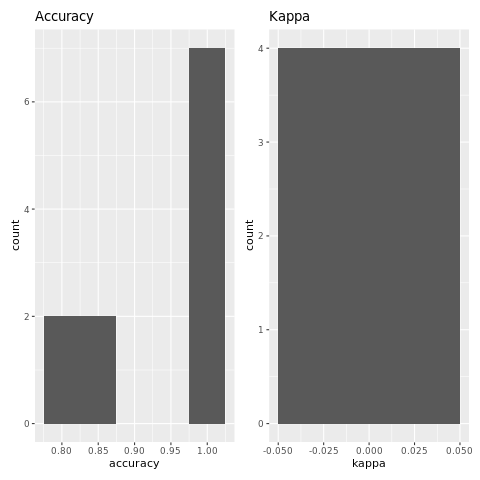

In [67]:
%%R
df_inner <- purrr::map(modl_lst_aqua, "results") %>% 
  purrr::map_dbl("accuracy") %>% 
  stack() %>% 
  dplyr::select(site = ind, accuracy = values) %>% 
  left_join(
    purrr::map(modl_lst_aqua, "results") %>% 
      purrr::map_dbl("kappa") %>% 
      stack() %>% 
      dplyr::select(site = ind, kappa = values),
    by = "site"
  )

df_inner %>% knitr::kable()

df_inner %>% 
  summarise(kappa_mean = mean(kappa), accuracy_mean = mean(accuracy),
            kappa_median = median(kappa), accuracy_median = median(accuracy),
            kappa_sd = sd(kappa), accuracy_sd = sd(accuracy)) %>% 
  knitr::kable()
# why so little bins? was 5
gg1 <- df_inner %>% 
  ggplot(aes(x = kappa, y = ..count..)) +
  geom_histogram(bins = 5) +                       
  labs(title = "Kappa")

gg2 <- df_inner %>% 
  ggplot(aes(x = accuracy, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = "Accuracy")

library(patchwork)
gg2 + gg1

Combine predictions on test sets from the inner loop (on the single held-out site). This is the most relevant metric here!

In [68]:
%%R
df_test_inner <- purrr::map_dfr(modl_lst_aqua, "df_test")
confusionMatrix( data = df_test_inner$pred,
                 reference = df_test_inner$is_flue_drought, 
                 positive = "TRUE"
                 )

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   146    8
     TRUE      2    0
                                          
               Accuracy : 0.9359          
                 95% CI : (0.8853, 0.9688)
    No Information Rate : 0.9487          
    P-Value [Acc > NIR] : 0.8212          
                                          
                  Kappa : -0.0209         
                                          
 Mcnemar's Test P-Value : 0.1138          
                                          
            Sensitivity : 0.00000         
            Specificity : 0.98649         
         Pos Pred Value : 0.00000         
         Neg Pred Value : 0.94805         
             Prevalence : 0.05128         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.01282         
      Balanced Accuracy : 0.49324         
                                          
       'Positive' Class : TRUE            
                     

### Drought magnitude

Predictions of drought magnitude.

Single split (global model)

Must be split by site.

In [69]:
%%R
set.seed(1982)
nsites_train <- floor(0.8*length(sites)) #18
sites_train <- sample(sites, nsites_train)
df_train <- ddf_sub %>% 
  dplyr::filter(site %in% sites_train)
df_test <- ddf_sub %>% 
  dplyr::filter(!(site %in% sites_train))

Train model on a single training set and evaluate on the single testing set from the initial split


In [70]:
%%R
filn <- "./results/modl_flue_nnet_GLOBAL_lst_aqua4.Rdata"
if (!file.exists(filn)){
  modl_lst_aqua <- wrap_ml( df = df_train,
                   nam_target = "flue",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = all_bands_and_lst_aqua,
                   tune = TRUE,
                   inner = FALSE,
                   classification = FALSE
                  )
  ## save model object
  save(modl_lst_aqua, file = filn)
} else {
  load(filn)
}

## Leave-group-out split 

This is to assess the variance of evaluation metrics derived from test sets.

In [71]:
%%R
filn <- "./results/modl_flue_nnet_INNER_lst_aqua4.Rdata"
if (!file.exists(filn)){
  modl_lst_aqua <- wrap_ml( df = ddf_sub,
                   nam_target = "flue",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = all_bands_and_lst_aqua,
                   tune = FALSE,
                   inner = TRUE,
                   classification = FALSE
                  )
  
  ## save model object (WARNING: IS A BIT BIG)
  save(modl_lst_aqua, file = filn)
} else {
  load(filn)
}

Get evaluation results across left-out sites from inner loop.


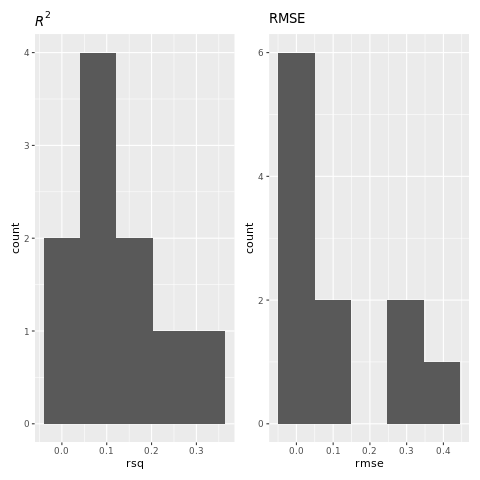

In [72]:
%%R
df_inner <- purrr::map_dfr(modl_lst_aqua, "results") %>% 
  pivot_wider(names_from = .metric, values_from = .estimate) %>% 
  dplyr::select(-.estimator)

df_inner %>% knitr::kable()

df_inner %>% 
  summarise(rmse_mean = mean(rmse), rsq_mean = mean(rsq),
            rmse_median = median(rmse), rsq_median = median(rsq),
            rmse_sd = sd(rmse), rsq_sd = sd(rsq)) %>% 
  knitr::kable()

gg1 <- df_inner %>% 
  ggplot(aes(x = rmse, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = "RMSE")

gg2 <- df_inner %>% 
  ggplot(aes(x = rsq, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = expression(italic(R)^2))

gg2 + gg1

Combine predictions on test sets from the inner loop (on the single held-out site). This is the most relevant metric here!


$df_metrics
# A tibble: 12 × 3
   .metric  .estimator .estimate
   <chr>    <chr>          <dbl>
 1 rmse     standard     0.130  
 2 rsq      standard     0.00670
 3 mae      standard     0.0626 
 4 n        standard   156      
 5 slope    standard    -0.344  
 6 mean_obs standard     1.00   
 7 prmse    standard     0.130  
 8 pmae     standard     0.0624 
 9 bias     standard    -0.0193 
10 pbias    standard    -0.00506
11 cor      standard    -0.0819 
12 cor_test standard     0.310  

$gg


R[write to console]: `geom_smooth()` using formula 'y ~ x'




$linmod

Call:
lm(formula = obs ~ mod, data = df)

Coefficients:
(Intercept)          mod  
     1.3409      -0.3439  


$results
# A tibble: 1 × 6
      rsq  rmse    mae    bias  slope     n
    <dbl> <dbl>  <dbl>   <dbl>  <dbl> <dbl>
1 0.00670 0.130 0.0626 -0.0193 -0.344   156



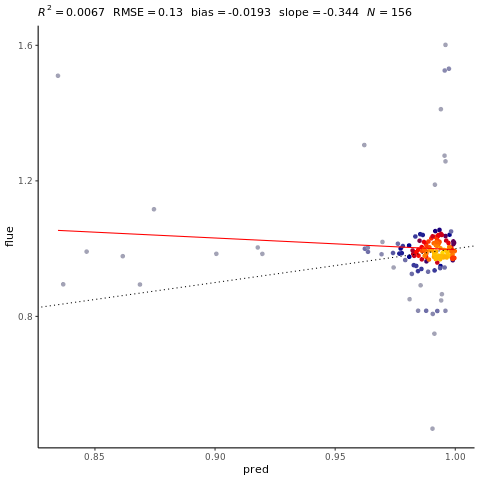

In [73]:
%%R
df_test_inner <- purrr::map_dfr(modl_lst_aqua, "df_test")

df_test_inner %>% 
  rbeni::analyse_modobs2("pred", "flue", type = "heat")

In [74]:
%%R
df_test_inner

# A tibble: 156 × 41
   site  date        flue is_flue_drought    YY    MM    DD lst_aqua   b01   b02
   <chr> <date>     <dbl> <fct>           <dbl> <dbl> <dbl>    <dbl> <dbl> <dbl>
 1 DE-O… 2009-11-15 0.959 FALSE            2009    11    15     281. 181.  1361.
 2 DE-O… 2009-11-18 0.976 FALSE            2009    11    18     276. 190.  1074.
 3 DE-O… 2009-11-25 0.992 FALSE            2009    11    25     282.  89.7 1118.
 4 DE-O… 2010-10-11 0.963 FALSE            2010    10    11     285. 134.  1275.
 5 DE-O… 2010-10-30 0.989 FALSE            2010    10    30     284. 233.  1578.
 6 DE-O… 2012-10-20 1.04  FALSE            2012    10    20     293. 204.  1634.
 7 DE-O… 2013-10-22 0.997 FALSE            2013    10    22     289. 901.  2428.
 8 DE-O… 2013-12-12 0.978 FALSE            2013    12    12     280. 303.  1606.
 9 DE-O… 2013-12-16 1.02  FALSE            2013    12    16     282. 134.  1630 
10 DE-O… 2013-12-17 1.02  FALSE            2013    12    17     278.  79.2 1334.
# … wit

# Starting to write a more efficient way to get one data frame before deciding that copy pasting and adapting a few things is faster

In [25]:
%%R
# read in criteria and return a map of which bands are to use (TRUE) and if corrections were performed (TRUE)\
# based on looping through QC_Data
# QC_Data should contain an the quality control from the satellite product as well as conversion for each bit named Bit<number> in decreasing order
# criteria should contain 3 columns QualityTarget(containing a string of the target name), 
#                                   QC_Flags(containing the flag needed for the flag to be TRUE starting with the LSB if LSB=TRUE), 
#                                   Position(containing the location of QC_Flags in the form of: <startingBit>_<endingBit> with <startingBit> < <endingBit> in increasing order
# satellite contains a string of the satellite name
quality_control <- function(QC_Data, criteria, satellite, length = 32, LSB = TRUE){
    #create the df quality_mapping
    names <- paste(satellite, criteria$QualityTarget, sep = "_qc_")
    quality_mapping  <- data.frame(t(names), stringsAsFactors=FALSE)
    #fill the df quality_mapping
    if(LSB && length == 32){
        for (i in 2:nrow(QC_Data)){
            for (i in 1:nrow(criteria)){
                interval <- strsplit(criteria$Position, split = "_")
                a <- interval[[1]][1]
                z <- interval[[1]][2]
                flag <- ""
                #for (j n 1:ncol(QC_Data)){
                    #QC_Data[i][length-j+1]
                #}
                       
            }
        }
    }
    else{
        print("Until now all MODIS products have a quality control where Bit0 is the least significant bit with an unsigned 32 Bit integer. If you are sure you found an exception please implement this in the quality_control function.")
    }
    # use the QualityTargets as names of the variables for the df and return it
    var_names(quality_mapping) <- as.character(unlist(quality_mapping[1,]))
    quality_mapping[-1]
    return(quality_mapping)
}

In [38]:
# # adds a column of passed values with NA if quality control failed            
# # !!!!!!!!!!!!!! DOES NOT WORK !!!!!!!!!!!!!!!!!!!
# mod09$b01_qc_mapped <- map_if(mod09$sur_refl_b01, mod09$qc_flag_b01, mod09$sur_refl_b01, else = NA)
# mod09$b02_qc_mapped <- map_if(mod09$sur_refl_b02, mod09$qc_flag_b02, mod09$sur_refl_b02, else = NA)
# mod09$b03_qc_mapped <- map_if(mod09$sur_refl_b03, mod09$qc_flag_b03, mod09$sur_refl_b03, else = NA)
# mod09$b04_qc_mapped <- map_if(mod09$sur_refl_b04, mod09$qc_flag_b04, mod09$sur_refl_b04, else = NA)
# mod09$b05_qc_mapped <- map_if(mod09$sur_refl_b05, mod09$qc_flag_b05, mod09$sur_refl_b05, else = NA)
# mod09$b06_qc_mapped <- map_if(mod09$sur_refl_b06, mod09$qc_flag_b06, mod09$sur_refl_b06, else = NA)
# mod09$b0_qc_mapped7 <- map_if(mod09$sur_refl_b07, mod09$qc_flag_b07, mod09$sur_refl_b07, else = NA)


SyntaxError: invalid syntax (1380011949.py, line 2)

In [42]:
%%R
mod09$b01f <- NA
mod09$b01f[mod09$qc_flag_b01==TRUE] <-mod09$sur_refl_b01
mod09$b02f <- NA
mod09$b02f[mod09$qc_flag_b02==TRUE] <-mod09$sur_refl_b02
mod09$b03f <- NA
mod09$b03f[mod09$qc_flag_b03==TRUE] <-mod09$sur_refl_b03
mod09$b04f <- NA
mod09$b04f[mod09$qc_flag_b04==TRUE] <-mod09$sur_refl_b04
head(mod09$b01f)

[1] 4777.00  798.75 6264.75  658.75  522.00  781.75


In [ ]:
%%R
#mod09$sur_refl_b01[mod09$sur_refl_b01==NA]

In [45]:
%%R
# is not the same
# mod09$b01 == mod09$b01f

NULL


   [1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE 
   
   [13]  TRUE  TRUE  TRUE  TRUE  TRUE    NA FALSE FALSE    NA    NA    NA FALSE
   
   [25] FALSE FALSE FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [49] FALSE    NA    NA FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE    NA
   
   [61] FALSE    NA    NA    NA    NA FALSE FALSE FALSE FALSE    NA    NA    NA
   
   [73]    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE    NA FALSE FALSE FALSE
   
  [109] FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE    NA FALSE
  
  [121] FALSE FALSE FALSE FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  
  [133] FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [15]:
%%R
# create flags for quality control
# Quality control according to https://lpdaac.usgs.gov/documents/306/MOD09_User_Guide_V6.pdf
# Table 10
# Bit no. 0 (least significant bit) and 1: 00          all bands imediately accepted 
#                                          01, 10, 11  after further checks of each band
# Bit no. 2-5 + 4(n-1):                    0000        band n is accepted 
# Bit no. 30                               0           no atmospheric correction performed
# Bit no. 31                               0           no adjacency correction performed
qflags_500 <- sort(unique(mod09$QC_500m))    # 32 bits
QualityTarget <- c("all_bands", "b1", "b2", "b3", "b4", "b5", "b6", "b7", "atmospheric_correction", "adjacency_correction")   # what can be determined by QC_500
QC_Flags <- c("00", "0000", "0000", "0000", "0000", "0000", "0000", "0000", "1", "1")        # flag such that QualityTarget is TRUE
Position  <- c("0_1", "2_5", "6_9", "10_13", "14_17", "18_21", "22_25", "26_29", "30_30","31_31")       # which Bits are relevant for QC_Flags for each QualityTarget
criteria_mod09a1 <- data.frame(QualityTarget, QC_Flags, Position)
criteria_mod09a1

            QualityTarget QC_Flags Position
1               all_bands       00      0_1
2                      b1     0000      2_5
3                      b2     0000      6_9
4                      b3     0000    10_13
5                      b4     0000    14_17
6                      b5     0000    18_21
7                      b6     0000    22_25
8                      b7     0000    26_29
9  atmospheric_correction        1    30_30
10   adjacency_correction        1    31_31


In [71]:
%%R
dates_mod09  <- mod09 %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))
dates_mod09  <- dates_mod09$date

In [81]:
%%R
data_lst_MOD11A2 <- df[df$band == "LST_Day_1km", ]

In [74]:
# %%R
# data_lst_MOD11A2 <- data_lst_MOD11A2 %>%   ########### empty after drop_na()
#   drop_na()

In [85]:
%%R
dates_lst_MOD11A2 <- data_lst_MOD11A2$calendar_date

In [90]:
%%R
summary(data_lst_MOD11A2)

   xllcorner           yllcorner           cellsize         nrows      
 Min.   :-10666385   Min.   :-4165181   Min.   :926.6   Min.   :1.000  
 1st Qu.: -6599426   1st Qu.: 3534149   1st Qu.:926.6   1st Qu.:9.000  
 Median :   729254   Median : 4710964   Median :926.6   Median :9.000  
 Mean   :   505756   Mean   : 3593696   Mean   :926.6   Mean   :8.996  
 3rd Qu.:  2487989   3rd Qu.: 5427245   3rd Qu.:926.6   3rd Qu.:9.000  
 Max.   : 15471865   Max.   : 8775143   Max.   :926.6   Max.   :9.000  
     ncols           band              units              scale          
 Min.   :1.000   Length:10480092    Length:10480092    Length:10480092   
 1st Qu.:9.000   Class :character   Class :character   Class :character  
 Median :9.000   Mode  :character   Mode  :character   Mode  :character  
 Mean   :8.996                                                           
 3rd Qu.:9.000                                                           
 Max.   :9.000                                      

In [ ]:
%%R

In [89]:
%%R
sum(dates_mod09 %in% dates_lst_MOD11A2)

[1] 182320
